# Installing and Importing Required Libraries

In [ ]:
! sudo apt-get install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
! pip install midi2audio

In [ ]:
! pip install soundfile

In [ ]:
import matplotlib.pyplot as plt
import librosa
from music21 import *
from midi2audio import FluidSynth
import torch
import numpy as np

# Playing Around With Chromas

In [ ]:
import numpy as np

c_major = scale.MajorScale('C')
scale_notes = c_major.getPitches()

# Create a stream with random notes from the scale
s = stream.Stream()

for _ in range(50):  # Generate 50 random notes
    # Pick a random note from the scale
    random_note = np.random.choice(scale_notes)
    n = note.Note(random_note)
    n.quarterLength = 0.5  # eighth notes
    s.append(n)

# Export as MIDI
mf = midi.translate.streamToMidiFile(s)
mf.open('c_major_sample.mid', 'wb')
mf.write()
mf.close()

In [ ]:
s.show('midi')

In [ ]:
from midi2audio import FluidSynth
fs = FluidSynth()
midi_file = 'c_major_sample.mid'
wav_file = 'output.wav'
fs.midi_to_audio(midi_file, wav_file)

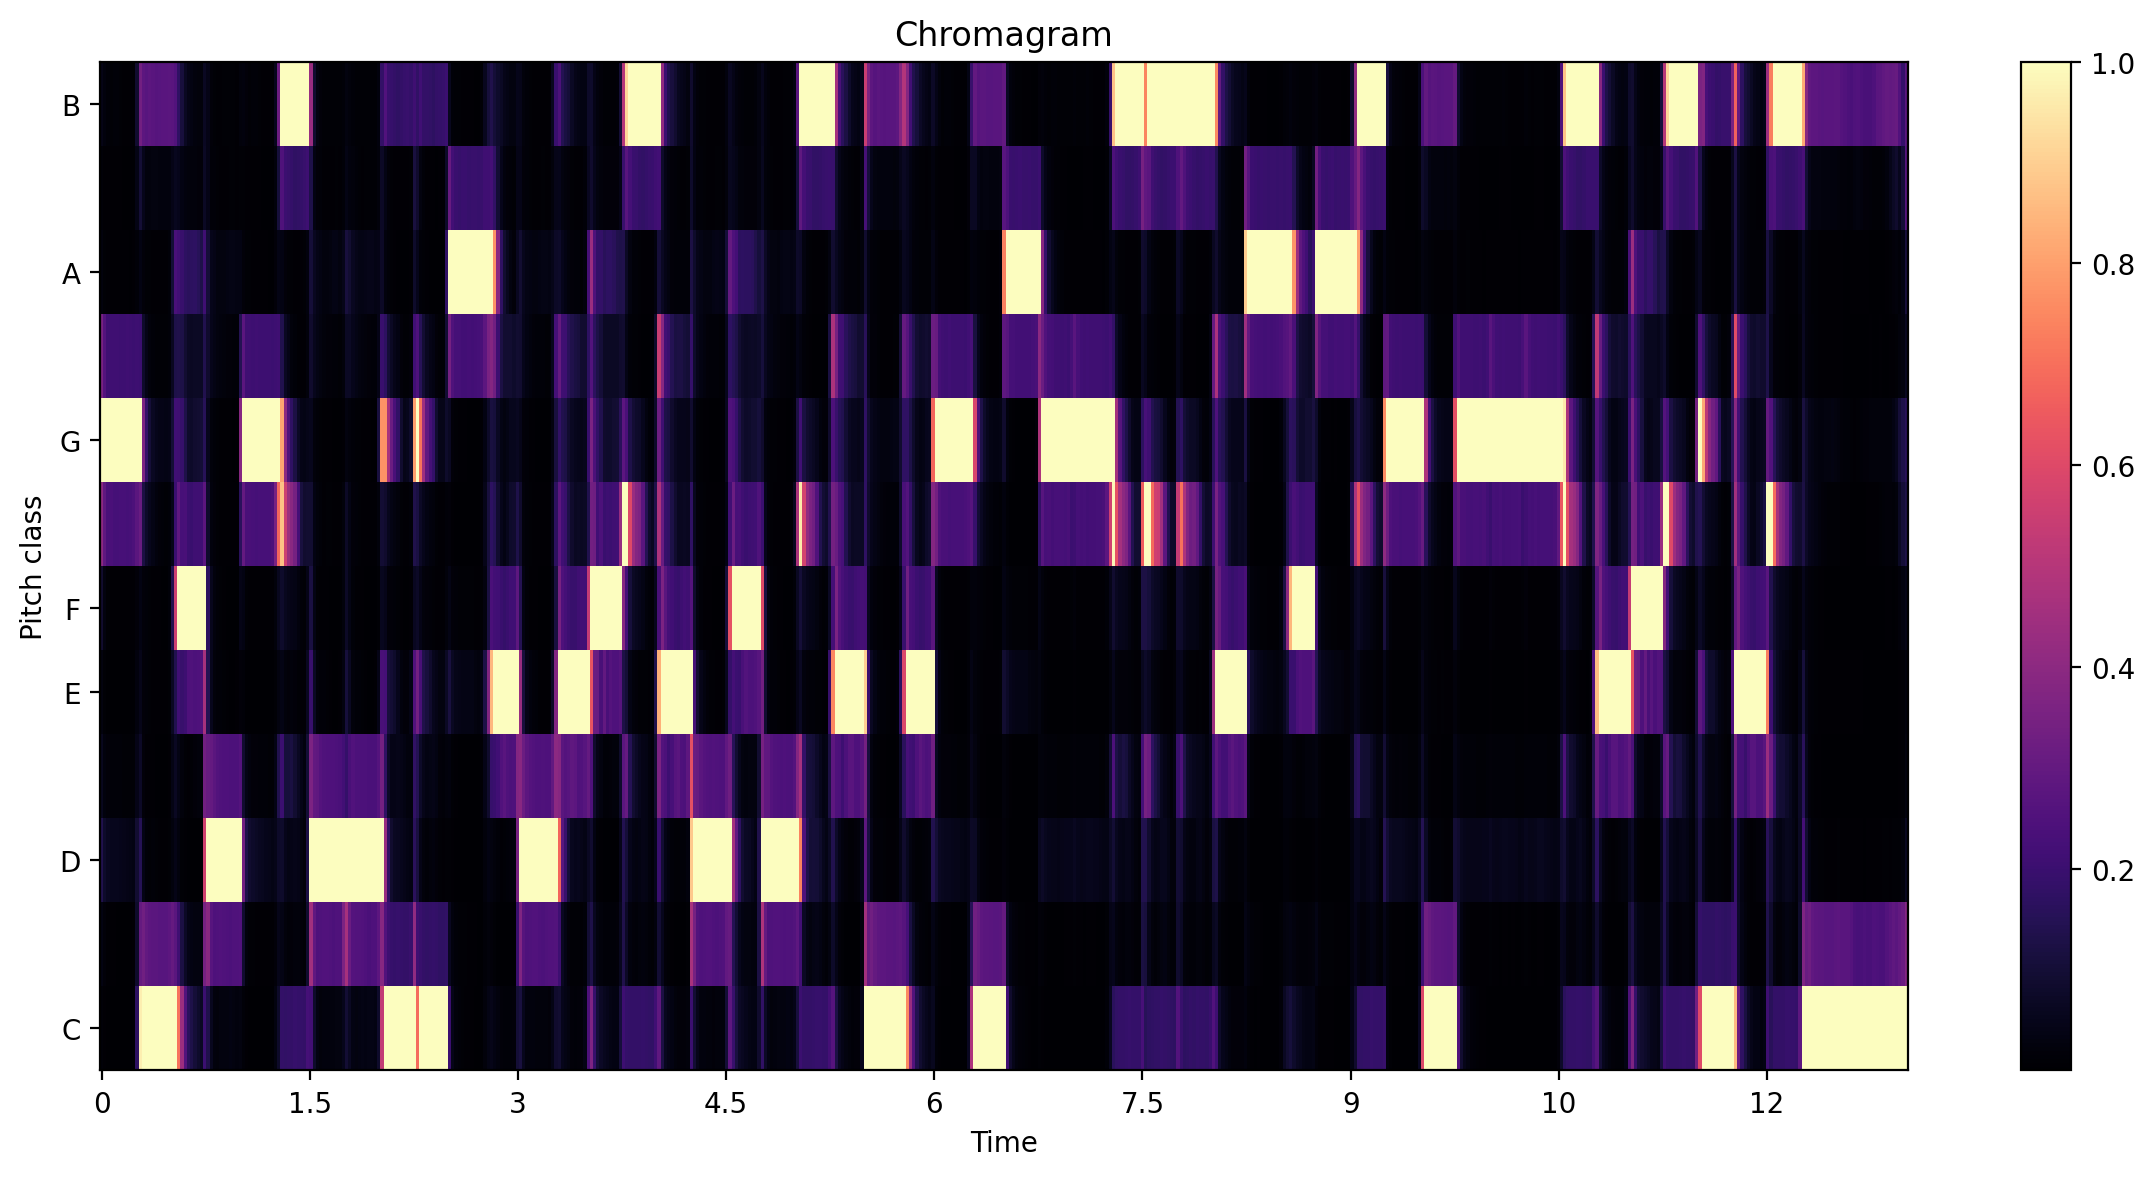

In [ ]:
y, sr = librosa.load('output.wav')
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

plt.figure(figsize=(12, 6))
librosa.display.specshow(chroma, sr=sr, y_axis='chroma', x_axis='time')
plt.title('Chromagram')
plt.colorbar()
plt.tight_layout()
plt.show()

# Dataset Generation

## Scales() Class — Synthetic Music Scale Dataset Generator

The `Scales()` class is designed to generate synthetic audio data of musical scales, convert the audio into chromagrams, and label each sample with its corresponding scale index. This setup is ideal for training deep learning models (e.g., CNNs) to classify musical scales from audio.

---

### 🔧 Constructor Parameters:
- `scale_list (list of str)`: List of root notes (e.g., ['C', 'C#', ..., 'B']).
- `scale_types (list of str)`: Scale modes (e.g., ['Major', 'Minor']).
- `num_samples (int)`: Number of samples to generate.
- `num_notes (int)`: Number of notes in each generated melody.
- `audio_duration (float)`: Duration of each audio sample (optional, not directly used in current version).
- `sampling_rate (int)`: Audio sampling rate (used for chroma extraction via librosa).

---

### 🧠 Key Methods:

- `generate_scale(scale_name, scale_type, melody, num_notes)`:  
  Randomly selects notes from the given scale and appends them to a `music21.stream`.

- `generate_sample()`:  
  Randomly selects a scale, generates notes, exports as MIDI and WAV using FluidSynth.

- `audio_to_chroma(audio_file)`:  
  Loads the WAV file and converts it to a chromagram using `librosa.feature.chroma_stft()`.  
  Returns a PyTorch tensor of shape `[1, 12, T]`.

- `scale_to_index(scale_name, scale_type)`:  
  Maps a `(scale_name, scale_type)` combo to a unique integer label (0–23 for 12 majors + 12 minors).

- `generate_data()`:  
  Full pipeline: generates a sample, converts to chroma, returns `(chroma_tensor, scale_index)`.

- `save_data(data, output_file)`:  
  Saves a list of `(chroma_tensor, scale_index)` pairs to a `.csv` file.

---

### 📦 Output:
Each sample is represented as:
- `chroma_tensor`: A chromagram of shape `[1, 12, T]`.
- `scale_index`: An integer label (0–23) identifying the scale.

These samples are well-suited for training deep learning models to predict musical scales from audio data.

---

### 💡 Future Additions:
- Support for more modes (e.g., Dorian, Phrygian)
- Option to save/load `.pt` datasets
- Integration with PyTorch Dataset class
- Configurable instrument/timbre/random tempo

---


In [98]:
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import librosa
# from music21 import *
# from midi2audio import FluidSynth
# import random
# import pandas as pd
# import os
# import glob
# import soundfile as sf

# random.seed(42)

# class Scales():
#   def __init__(self, scale_list, scale_types, num_samples, num_notes, note_duration, sampling_rate, sample_counter):
#     self.scale_list = scale_list
#     self.scale_types = scale_types
#     self.num_samples = num_samples
#     self.num_notes = num_notes
#     self.note_duration = note_duration
#     self.sampling_rate = sampling_rate
#     self.sample_counter = sample_counter

#     self.fs = FluidSynth()
#     # Make temp folder
#     os.makedirs("temp", exist_ok=True)

#   def generate_scale(self, scale_name, scale_type, melody, num_notes, note_duration):
#     scale_generated = scale.MinorScale(scale_name)

#     if scale_type == 'Major': scale_generated = scale.MajorScale(scale_name)

#     scale_notes = scale_generated.getPitches()

#     # Generate num_notes random notes
#     for _ in range(num_notes):
#       # Pick a random note from the scale
#       random_note = np.random.choice(scale_notes)
#       n = note.Note(random_note)
#       n.quarterLength = self.note_duration # eighth notes
#       melody.append(n)

#     # return stream
#     return melody

#   def generate_sample(self):
#     # Determine fixed number of samples per scale
#     samples_per_scale = self.num_samples // 24
#     scale_pool = [(root, stype) for root in self.scale_list for stype in self.scale_types]
#     scale_index = (self.sample_counter % len(scale_pool))
#     scale_name, scale_type = scale_pool[scale_index]
#     self.sample_counter += 1

#     melody = stream.Stream()
#     melody = self.generate_scale(scale_name, scale_type, melody, self.num_notes, self.note_duration)

#     midi_file = f'{scale_name}_{scale_type}.mid'
#     mf = midi.translate.streamToMidiFile(melody)
#     mf.open(midi_file, 'wb')
#     mf.write()
#     mf.close()

#     self.fs = FluidSynth()
#     audio_file = f'{scale_name}_{scale_type}.wav'
#     self.fs.midi_to_audio(midi_file, audio_file)

#     return audio_file, midi_file, scale_name, scale_type

#   def audio_to_chroma(self, audio_file):
#     # load audio file
#     y, sr = sf.read(audio_file)

#     if y.ndim > 1: y = y.mean(axis=1)  # Convert to mono if stereo

#     # y, sr = librosa.load(audio_file, sr = self.sampling_rate)

#     # generate chroma
#     chroma = librosa.feature.chroma_stft(y=y, sr=sr)

#     # convert to tensor of shape [1, 12, T]
#     chroma_tensor = torch.tensor(chroma).unsqueeze(0)

#     return chroma_tensor

#   def scale_to_index(self, scale_name, scale_type):
#         # changing scale_name to fit dictionary
#         scale_name = f'{scale_name}_{scale_type.lower()}'
#         scale_to_index = {
#             'C_major': 0, 'C#_major': 1, 'D_major': 2, 'D#_major': 3, 'E_major': 4, 'F_major': 5,
#             'F#_major': 6, 'G_major': 7, 'G#_major': 8, 'A_major': 9, 'A#_major': 10, 'B_major': 11,
#             'C_minor': 12, 'C#_minor': 13, 'D_minor': 14, 'D#_minor': 15, 'E_minor': 16, 'F_minor': 17,
#             'F#_minor': 18, 'G_minor': 19, 'G#_minor': 20, 'A_minor': 21, 'A#_minor': 22, 'B_minor': 23
#         }
#         return scale_to_index.get(scale_name, -1)  # Return -1 if not found

#   # Main calling method, of sorts
#   def generate_data(self):
#     audio_file, midi_file, scale_name, scale_type = self.generate_sample()

#     chroma_tensor = self.audio_to_chroma(audio_file)

#     scale_index = self.scale_to_index(scale_name, scale_type)

#     # Clean up files
#     try:
#         if os.path.exists(audio_file):
#             os.remove(audio_file)
#         if os.path.exists(midi_file):
#             os.remove(midi_file)
#     except Exception as e:
#         print(f"Error deleting files: {e}")

#     return chroma_tensor, scale_index

#   def save_data(self, data, output_file):
#         # Convert the data to a DataFrame and save it as CSV

#         df = pd.DataFrame(data, columns=['chroma_tensor', 'scale_index'])

#         df.to_csv(output_file, index=False)

In [99]:
# import time
# from tqdm import tqdm

# scale_list = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
# scale_types = ['Major', 'Minor']
# s = Scales(scale_list=scale_list, scale_types=scale_types, num_samples=1, num_notes=25, note_duration=0.25, sampling_rate=16000, sample_counter=0)

# data = []

# for _ in tqdm(range(s.num_samples)):
#     chroma_tensor, scale_index = s.generate_data()
#     print(chroma_tensor)
#     data.append([chroma_tensor, scale_index])
#     time.sleep(0.1)

# # Save the dataset to CSV
# s.save_data(data, 'synthetic_scale_dataset.csv')
# df = pd.read_csv('/content/synthetic_scale_dataset.csv')

# scale_index_distribution = df['scale_index'].value_counts()


## Multiprocessing

In [103]:
import os
import random
import numpy as np
import torch
import librosa
import pandas as pd
import soundfile as sf
from uuid import uuid4
from multiprocessing import Pool
from music21 import stream, note, scale, midi
from midi2audio import FluidSynth


class Scales:
    def __init__(self, scale_list, scale_types, num_samples, num_notes, note_duration, sampling_rate):
        self.scale_list = scale_list
        self.scale_types = scale_types
        self.num_samples = num_samples
        self.num_notes = num_notes
        self.note_duration = note_duration
        self.sampling_rate = sampling_rate

        os.makedirs("temp", exist_ok=True)

    @staticmethod
    def generate_single_sample(args):
        scale_name, scale_type, num_notes, note_duration, sampling_rate = args

        try:
            fs = FluidSynth()
            scale_obj = scale.MajorScale(scale_name) if scale_type == "Major" else scale.MinorScale(scale_name)
            scale_notes = scale_obj.getPitches()
            melody = stream.Stream()

            for _ in range(num_notes):
                n = note.Note(np.random.choice(scale_notes))
                n.quarterLength = note_duration
                melody.append(n)

            uid = str(uuid4())[:8]
            midi_file = f"temp/{scale_name}_{scale_type}_{uid}.mid"
            audio_file = f"temp/{scale_name}_{scale_type}_{uid}.wav"

            mf = midi.translate.streamToMidiFile(melody)
            mf.open(midi_file, 'wb')
            mf.write()
            mf.close()

            fs.midi_to_audio(midi_file, audio_file)

            y, sr = sf.read(audio_file)
            if y.ndim > 1:
                y = y.mean(axis=1)

            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_tensor = torch.tensor(chroma).unsqueeze(0)

            os.remove(midi_file)
            os.remove(audio_file)

            scale_key = f'{scale_name}_{scale_type.lower()}'
            scale_to_index = {
                'C_major': 0, 'C#_major': 1, 'D_major': 2, 'D#_major': 3, 'E_major': 4, 'F_major': 5,
                'F#_major': 6, 'G_major': 7, 'G#_major': 8, 'A_major': 9, 'A#_major': 10, 'B_major': 11,
                'C_minor': 12, 'C#_minor': 13, 'D_minor': 14, 'D#_minor': 15, 'E_minor': 16, 'F_minor': 17,
                'F#_minor': 18, 'G_minor': 19, 'G#_minor': 20, 'A_minor': 21, 'A#_minor': 22, 'B_minor': 23
            }

            scale_index = scale_to_index.get(scale_key, -1)
            return chroma_tensor, scale_index

        except Exception as e:
            print(f"[ERROR] Failed sample for {scale_name}_{scale_type}: {e}")
            return None  # Filter out failures

    def generate_dataset_parallel(self, num_workers=12):
        total_scales = [(root, stype) for root in self.scale_list for stype in self.scale_types]
        samples_per_scale = self.num_samples // len(total_scales)
        args_list = []

        for scale_name, scale_type in total_scales:
            for _ in range(samples_per_scale):
                args_list.append((scale_name, scale_type, self.num_notes, self.note_duration, self.sampling_rate))

        results = []
        with Pool(processes=num_workers) as pool:
            for result in tqdm(pool.imap_unordered(self.generate_single_sample, args_list), total=len(args_list)):
                if result is not None:
                    results.append(result)

        return results

    def save_data(self, data, output_file):
        df = pd.DataFrame(data, columns=['chroma_tensor', 'scale_index'])
        df['chroma_tensor'] = df['chroma_tensor'].apply(lambda x: x.numpy().flatten().tolist())
        df.to_csv(output_file, index=False)


In [ ]:
sc = Scales(
    scale_list=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'],
    scale_types=['Major', 'Minor'],
    num_samples=7200,
    num_notes=24,
    note_duration=0.25,
    sampling_rate=16000
)

data = sc.generate_dataset_parallel(num_workers=4)
sc.save_data(data, "scale_dataset.csv")
df = pd.read_csv('/content/scale_dataset.csv')
scale_index_distribution = df['scale_index'].value_counts()
scale_index_distribution

100%|██████████| 7200/7200 [43:14<00:00,  2.78it/s]


,count
scale_index,
0,300
12,300
1,300
13,300
2,300
14,300
3,300
15,300
4,300


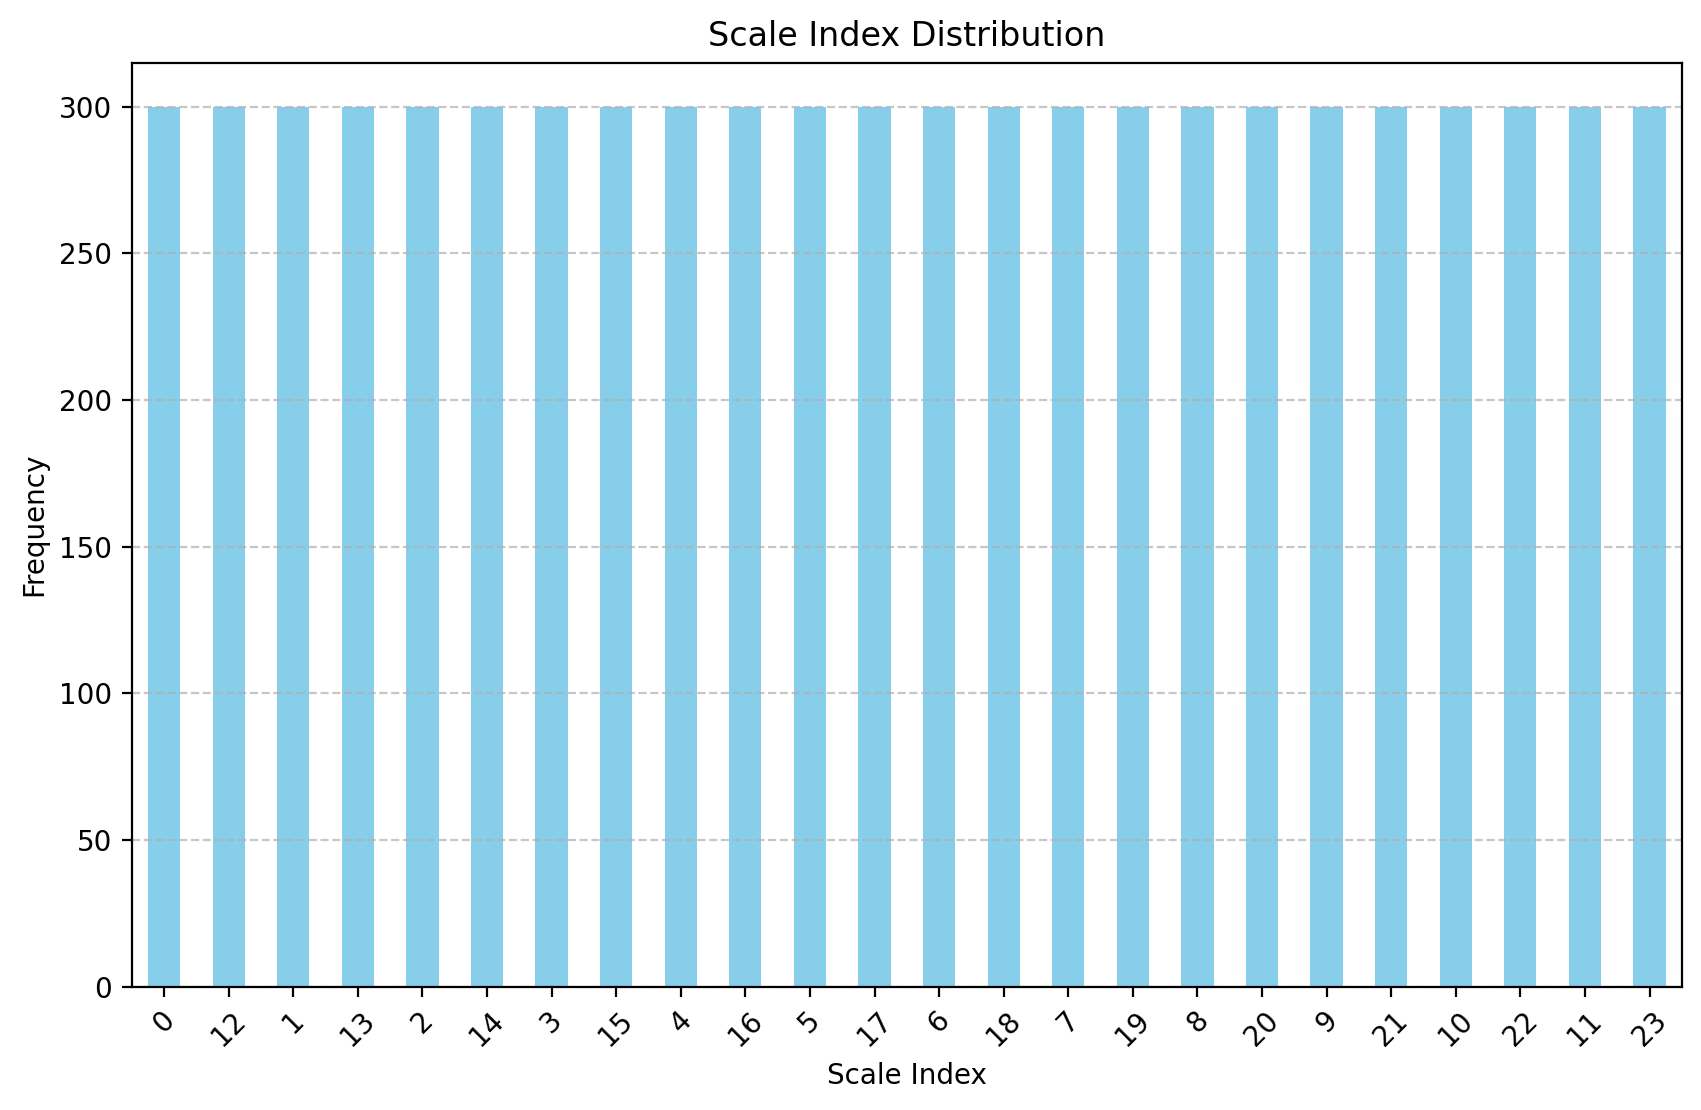

In [ ]:
# Plot the distribution
plt.figure(figsize=(10,6))
scale_index_distribution.plot(kind='bar', color='skyblue')
plt.title('Scale Index Distribution')
plt.xlabel('Scale Index')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Quick File Deletion, if needed

In [ ]:
import os
import glob

# Delete all .mid and .wav files in root or any folder
for ext in ("*.mid", "*.wav"):
    for file in glob.glob(ext):
        os.remove(file)

# Running Statistical Analyses

### Reconstructing Tensors

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm

df = pd.read_csv("scale_dataset.csv")

# Reconstruct chroma tensors
X = [torch.tensor(eval(row)).reshape(1, 12, -1) for row in tqdm(df['chroma_tensor'])]
y = df['scale_index'].tolist()

100%|██████████| 7200/7200 [01:47<00:00, 66.92it/s]


### Frequency of each scale

Balanced - 300 samples/scale for a total of 7200 samples.

<Axes: xlabel='scale_index', ylabel='count'>

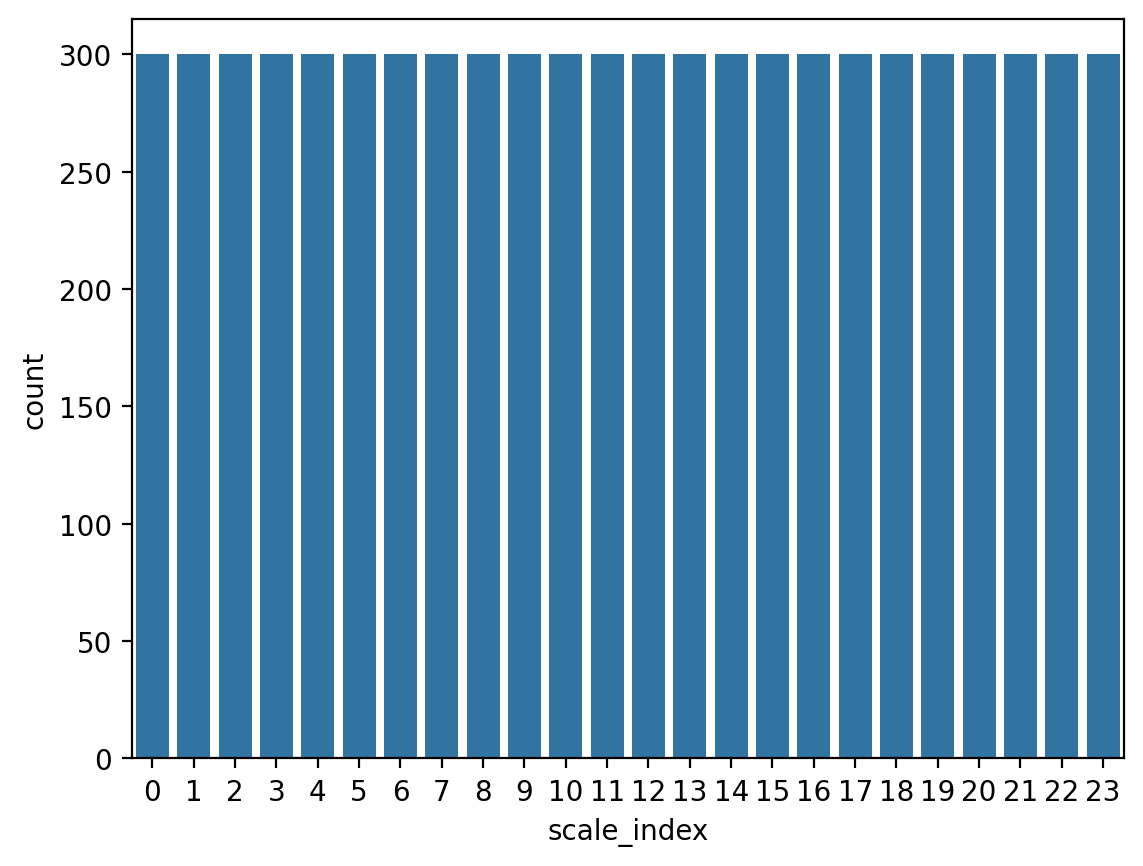

In [ ]:
import seaborn as sns
sns.countplot(x=df['scale_index'])

### Chroma Activation Per Pitch Class

This graph shows the average activation of each pitch class across our 7,200 chroma-based samples.

We observe a slight peak around G, G#, and A, indicating that these notes were more commonly emphasized across the dataset. However, the remaining pitch classes aren’t significantly lower, suggesting that no class is underrepresented or missing entirely.

This variability is expected and desirable, as it reflects natural tonal variation across different scales.



> Overall, the distribution confirms that our dataset has a healthy spread of pitch activity — a good sign for downstream learning tasks.



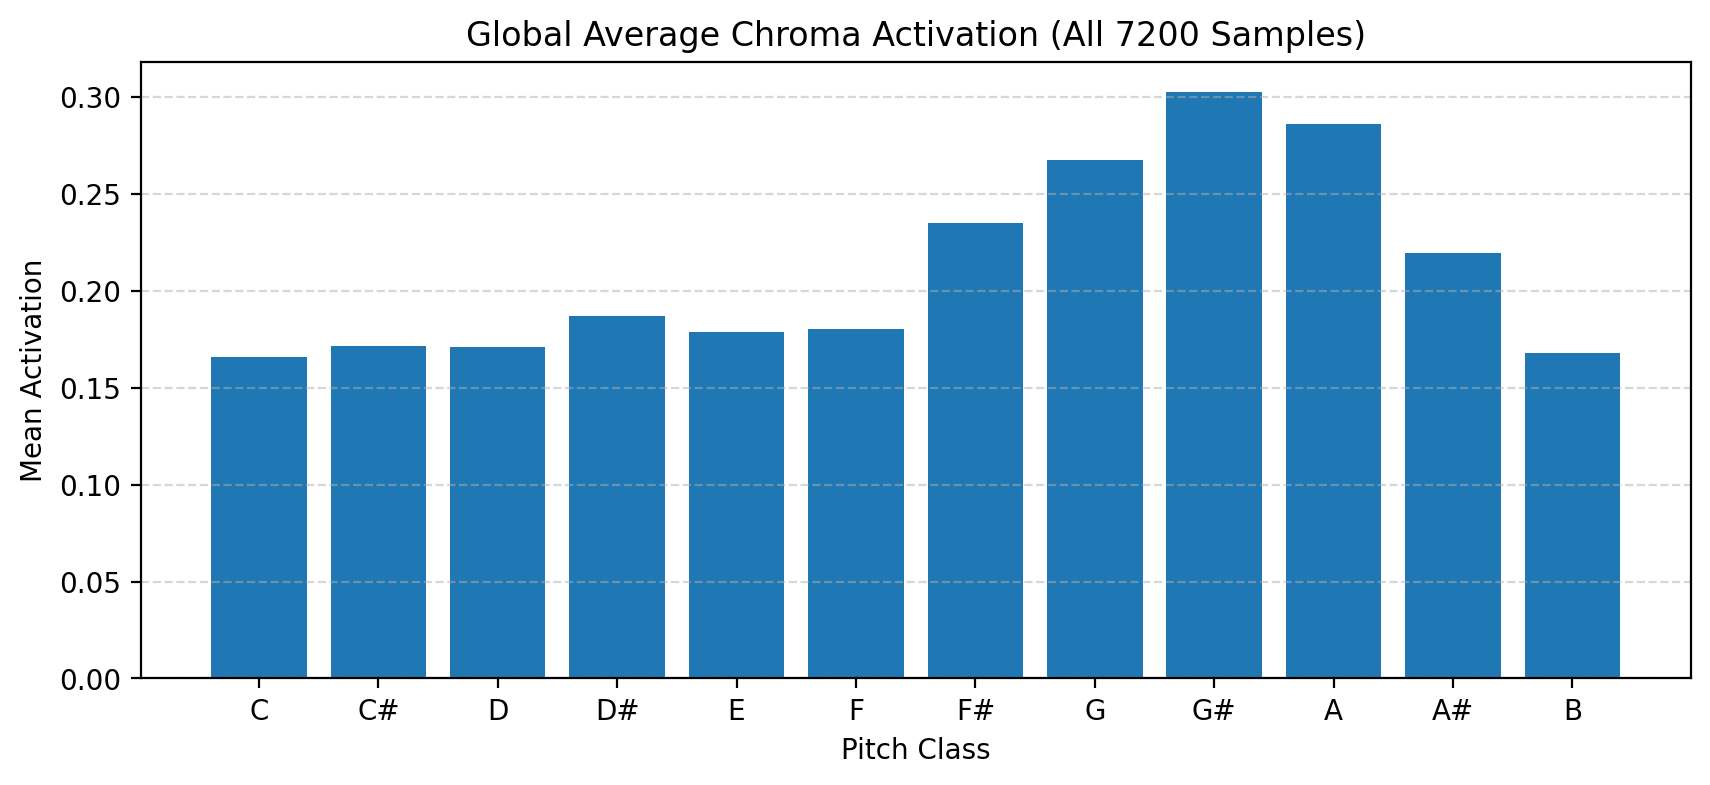

In [79]:
# Squeeze tensor to dimension [12]
chroma_vector = [chroma_tensor.mean(dim=2).squeeze(0) for chroma_tensor in X]
musical_fingerprint = torch.stack(chroma_vector).mean(dim=0)

pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F',
                 'F#', 'G', 'G#', 'A', 'A#', 'B']

plt.figure(figsize=(10, 4))
plt.bar(pitch_classes, musical_fingerprint.tolist())
plt.title("Global Average Chroma Activation (All 7200 Samples)")
plt.xlabel("Pitch Class")
plt.ylabel("Mean Activation")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()